# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook is based on Ben Moseley's blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/) and his original code which can be found [here](https://github.com/benmoseley/harmonic-oscillator-pinn). Please refer to Ben's blog post and code if you're interested.

This notebook differs from the original in that it
 - is based on **tensorflow 2** (instead of PyTorch) for neural network implementation
 - adds the option to **learn model parameters** while training the neural network

We will use a simple physical example problem to explain how PINNs work, how to implement them, and will demonstrate their benefit compared to regular neural nets as function approximators.

## Problem description

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
For the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
we can find the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

Please refer to the following blog post for more information: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow

- First, we will generate some **training data** along part of the exact solution
- then, we will implement a **regular neural network** and train it to approximate the function between input $t$ and output $x(t)$; we will examine the performance of the model prediction for a set of unseen data points $t$, around the training data points and in areas without training data 
- lastly, we will implement a **physics-informed neural network**, enforcing the ordinary differential equation at a number of collocation points over the time interval of interest; we will compare the predictive performance of the PINN to that of the regular NN.

In [1]:
# import necessary python packages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow.keras as keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

### 1. Generate training data

We define a function representing the analytical solution to the underdamped harmonic oscillator problem given above. 

In [2]:
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cosine = np.cos(phi+w*t)
    sine = np.sin(phi+w*t)
    exp = np.exp(-d*t)
    y  = exp*2*A*cosine
    return y

We pick an observation period of $T=1$ and compute the analytical solution $x(t)$ in this timeframe $t\in [0,1]$ for fixed model parameters $\delta = 2.0$ and $\omega_0 = 20.0$.
We select a total of 10 data points $(t,x(t))$ in the first half of the observation period as our training data for the neural network.

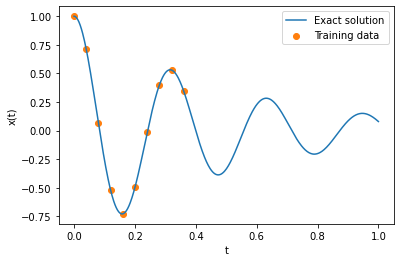

In [3]:
d, w0 = 2.0, 20.0

# get the analytical solution over the full domain
t = np.linspace(0,1,500)
x = oscillator(d, w0, t)

# slice out a small number of points from the left half of the domain: training data
t_data = t[0:200:20]
x_data = x[0:200:20]

# plot analytical solution and training data
plt.figure()
plt.plot(t, x, label="Exact solution")
plt.scatter(t_data, x_data, color="tab:orange", label="Training data")
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.show()

### 2. Regular neural network

First, we convert the training data arrays into the correct format and shape for working with tensorflow

In [4]:
# convert arrays to tf tensors
t_data_tf = tf.convert_to_tensor(t_data, dtype=DTYPE)
x_data_tf = tf.convert_to_tensor(x_data, dtype=DTYPE)

# reshape to correct format
T_data = tf.reshape(t_data_tf[:], shape=(t_data.shape[0],1))
X_data = tf.reshape(x_data_tf[:], shape=(x_data.shape[0],1))



2022-02-15 16:21:06.005442: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we define a standard neural network architecture, using `T_data` as input and train the neural net to predict `X_data`, by minimizing the MSE between `X_model` and `X_data` using gradient descent. Note that input and output of the network are both one-dimensional. We input one time value and receive one x-value as output.

In [5]:
## NN architecture
inputs = Input(shape=(1,))

hidden = Dense(32, activation='tanh')(inputs)

hidden = Dense(32, activation='tanh')(hidden)

out = Dense(1, activation='linear')(hidden)

model_NN = Model(inputs=inputs, outputs=out)
model_NN.compile(Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError()) 

# Describe model
model_NN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [6]:
# train regular NN 

from time import time
start = time()
history = model_NN.fit(T_data, X_data, epochs=1500, verbose=0,batch_size=10)
print('time taken : ',np.round(time() - start,3)) 

time taken :  1.849


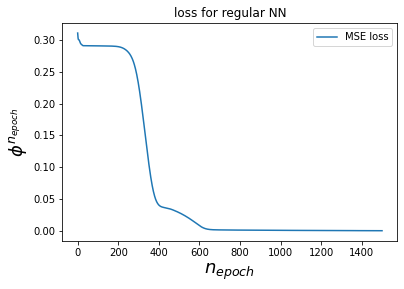

In [7]:
# plot loss over epochs

plt.plot(history.history['loss'])
plt.legend(['MSE loss'])
plt.xlabel('$n_{epoch}$',fontsize=18)
plt.ylabel('$\\phi^{n_{epoch}}$',fontsize=18)
plt.title('loss for regular NN')
plt.show()

### Result: regular NN

We use the model to predict $x(t)$ over the whole observation domain $t\in[0,1]$.
The trained neural network does well at approximating the analytical solution in the vicinity of the training data points in $t\in[0,0.4]$. All data points and the curvature of the trajectory are well matched. 

However, the neural network does not capture the analytical trajectory in the time regimen where we don't have training data points $t\in[0.4,1.0]$. There are no constraints on the solution here that the neural network could learn from. 

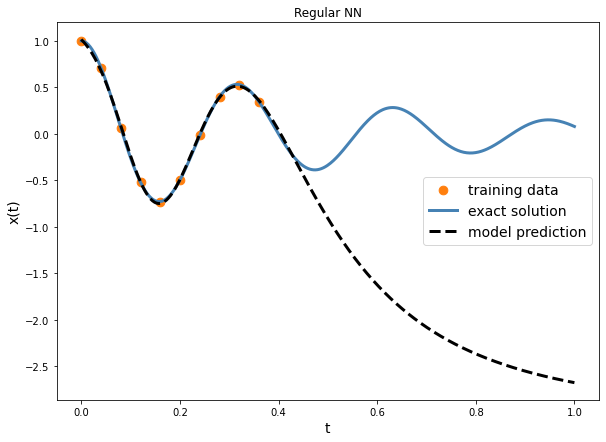

In [8]:
# examine posterior prediction

# create test-values over whole domain t=0...1
t_pred = np.linspace(0,1,500) 

# evaluate model prediction for t_pred
x_pred = model_NN.predict(t_pred)

# plot prediction
fig, ax2 = plt.subplots(figsize=(700/72,500/72))
ax2.set_title('Regular NN')
ax2.scatter(t_data,x_data,s=300,color="tab:orange", alpha=1.0,marker='.') #training data points 
ax2.plot(t,x,color="steelblue",linewidth=3.0)
ax2.plot(t_pred,x_pred,color="black",linewidth=3.0,linestyle="--")
ax2.set_ylabel('x(t)',fontsize=14)
ax2.set_xlabel('t',fontsize=14)
ax2.legend(('training data','exact solution','model prediction'), loc='center right',fontsize=14)

### 3. Physics-informed neural network

In order to improve the network's ability to approximate the solution, we will ensure that the solution is consistent with the undelying differential equation defining the oscillator problem 

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$

In addition to minimizing the difference between `X_data` and `X_model` at the training data points, we now also want to minimize the residual of the ODE (assuming $m=1$)

$$
r = \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx,
$$

at a number of collocation points along the whole observation period.
We used $\delta = 2.0$ and $\omega_0 = 20.0$ to generate our analytical solution, so the corresponding parameters for the ODE are (assuming $m=1$)

$$
\mu = 2 \delta = 4.0~,~k = \omega_0^2~=~400.0~.
$$

Let's first define the collocation points at which we want to enforce the ODE and convert them into tensorflow format:

In [9]:
t_physics = np.linspace(0,1,30)# sample locations over the problem domain: collocation points
no_physics_points = t_physics.shape[0]

# convert to tensor and correct shape
t_physics_tf = tf.convert_to_tensor(t_physics, dtype=DTYPE)
T_r = tf.reshape(t_physics_tf[:], shape=(t_physics.shape[0],1))

### PINN architecture

Next, we will define a class "PINNIdentificationNet" which we can call later to create an instance of a fully connected neural network architecture of desired complexity. 

Often, we know the physical laws behind a problem but we don't know the exact model parameters and want to learn them from the data. 

To this end, tensorflow allows to define trainable "variables" ([tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)) which will be trained together with the weights and biases of the neural net, but are not connected to the model input. In fact, we don't want them to be connected to the model input, because that would imply our model parameters are functions of time. 

We define one trainable variable for each model parameter $\mu$ and $k$, set an initial guess and set the argument `trainable=True`. If you don't want to learn the model parameters from the data, set `trainable=False` and the variable will be fixed to the set initial value.

In [10]:
# Define model architecture
class PINNIdentificationNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, 
            output_dim=1,
            num_hidden_layers=2, 
            num_neurons_per_layer=32,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
        # Initialize variable for mu, k: if trainable=True, will be trained along NN
        self.mu = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.mu_list = []
        
        self.k = tf.Variable(300.0, trainable=True, dtype=DTYPE)
        self.k_list = []
        
    def call(self, T):
        """Forward-pass through neural network."""
        Z = self.hidden[0](T)
        for i in range(1,self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

### PINN solver

We define a custom solver that allows us to compute the ODE residual associated loss over all collocation points at each training step and add it to the loss associated with the difference between model prediction and training data.

The function `get_r` computes the first and second derivatives of the model output with respect to the model inputs at the collocation points. The automatic differentiation features of tensorflow ([tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)) make this very easy. 

We then feed these derivatives to the function `fun_r` which returns the ODE residual at the collocation points based on the derivatives and the trainable model parameters `self.model.mu` and `self.model.k`. 

The function `loss_fn` sums up the computed residual loss at the collocation points and the mean squared error between model prediction and data at the training data points. 

`get_grad` and `solve_with_TFoptimizer` take care of the gradient descent method for updating the weights, biases, and trainable variables of the network.

The remaining functions are helper functions for tracking loss history and creating results plots. 

In [11]:
class PINNSolver_ID():
    def __init__(self, model, T_r):
        self.model = model
        
        # Store collocation points
        self.t = T_r[:,0:1]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t during this GradientTape
            tape.watch(self.t)
            
            # Compute current values u(t)
            u = self.model(self.t[:,0:1])
            
            u_t = tape.gradient(u, self.t)
            
        u_tt = tape.gradient(u_t, self.t)
        
        del tape
        
        return self.fun_r(u, u_t, u_tt)
    
    def fun_r(self, u, u_t, u_tt):
        return u_tt + self.model.mu*u_t + self.model.k*u
    
    def loss_fn(self, T, u):
        
        # Compute phi_r: loss coming from ODE residual
        r = self.get_r()
        phi_r = (1e-4)*tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add loss coming from difference between model prediction and training data
        for i in range(len(T)):
            u_pred = self.model(T[i:i+1,0:1])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, T, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(T, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, T, u, N=10000):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(T, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()
            
    def callback(self, tr=None):
        mu = self.model.mu.numpy()
        self.model.mu_list.append(mu)
        
        k = self.model.k.numpy()
        self.model.k_list.append(k)
        
        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e} mu = {:10.8e} k = {:10.8e}'.format(self.iter, self.current_loss, mu, k))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):
        
        n = 500
        t_pred = np.reshape(np.linspace(0,1,n),(n,1))
        x_pred = self.model(t_pred)

        # plot prediction
        fig, ax2 = plt.subplots(figsize=(700/72,500/72))
        ax2.set_title('PINN')
        ax2.scatter(t_data,x_data,s=300,color="tab:orange", alpha=1.0,marker='.') #observed data points 
        ax2.plot(t,x,color="steelblue",linewidth=3.0)
        ax2.plot(t_pred,x_pred,color="black",linewidth=3.0,linestyle="--")
        ax2.legend(('training data','exact solution','model prediction'), loc='upper right',fontsize=14)
        ax2.set_xlabel('t',fontsize=14)
        ax2.set_ylabel('x(t)',fontsize=14)
        
        return ax2
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(700/72,500/72))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$',fontsize=18)
        ax.set_ylabel('$\\phi^{n_{epoch}}$',fontsize=18)
        return ax
    
    def plot_loss_and_param(self, axs=None):

        color_mu = 'tab:blue'
        color_k = 'tab:red'

        fig = plt.figure(figsize=(1200/72,800/72))
        gs = fig.add_gridspec(2, 2)
        
        ax1 = plt.subplot(gs[0, 0:2])
        ax1 = self.plot_loss_history(ax1)
        
        ax2 = plt.subplot(gs[1, 0])
        ax2.plot(range(len(self.hist)), self.model.mu_list,'-',color=color_mu)
        ax2.set_ylabel('$\\mu^{n_{epoch}}$', color=color_mu, fontsize=18)
        ax2.set_xlabel('$n_{epoch}$',fontsize=18)
        
        ax3 = plt.subplot(gs[1, 1])
        ax3.plot(range(len(self.hist)), self.model.k_list,'-',color=color_k)
        ax3.set_ylabel('$k^{n_{epoch}}$', color=color_k, fontsize=18)
        ax3.set_xlabel('$n_{epoch}$',fontsize=18)

        return (ax1,ax2,ax3)

### Run PINN

Now, we just need to instantiate the model and solver and call the `solve_with_TFoptimizer` method to train the network. We decided to use a basic Adam optimizer with a fixed learing rate here.

In [12]:
# Initialize model
model = PINNIdentificationNet()
model.build(input_shape=(None,1))

# Initialize PINN solver
solver = PINNSolver_ID(model, T_r)

# Start timer
t0 = time()

lr = 1e-2
optim = tf.keras.optimizers.Adam(learning_rate=lr)
solver.solve_with_TFoptimizer(optim, T_data, X_data, N=20000)


# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.75611758e+00 mu = 9.90005314e-01 k = 2.99990021e+02
It 00100: loss = 2.97224355e+00 mu = 1.20082486e+00 k = 2.99574677e+02
It 00200: loss = 2.82821655e+00 mu = 2.04525232e+00 k = 2.99146912e+02
It 00300: loss = 4.62712407e-01 mu = 4.12871695e+00 k = 2.97757111e+02
It 00400: loss = 1.82347819e-01 mu = 5.41729879e+00 k = 2.96799744e+02
It 00500: loss = 1.42502919e-01 mu = 5.80323601e+00 k = 2.96266510e+02
It 00600: loss = 1.05116814e-01 mu = 5.74753714e+00 k = 2.96148560e+02
It 00700: loss = 8.25846270e-02 mu = 5.41656971e+00 k = 2.96638672e+02
It 00800: loss = 6.22222498e-02 mu = 5.05138540e+00 k = 2.97608124e+02
It 00900: loss = 5.60449362e-02 mu = 4.79953909e+00 k = 2.98698212e+02
It 01000: loss = 5.41084372e-02 mu = 4.68252420e+00 k = 2.99788574e+02
It 01100: loss = 5.22474498e-02 mu = 4.63962936e+00 k = 3.00876129e+02
It 01200: loss = 5.13149016e-02 mu = 4.62331057e+00 k = 3.01941528e+02
It 01300: loss = 5.00787199e-02 mu = 4.61613989e+00 k = 3.03006378e+02
It 014

It 11000: loss = 1.20125443e-03 mu = 4.08156633e+00 k = 3.85235626e+02
It 11100: loss = 1.35498517e-03 mu = 4.08188963e+00 k = 3.85838409e+02
It 11200: loss = 2.32724543e-03 mu = 4.07858849e+00 k = 3.86428955e+02
It 11300: loss = 8.22701666e-04 mu = 4.07600498e+00 k = 3.87004852e+02
It 11400: loss = 1.10558094e-03 mu = 4.08518696e+00 k = 3.87571930e+02
It 11500: loss = 8.65793787e-04 mu = 4.08218575e+00 k = 3.88127258e+02
It 11600: loss = 4.69513657e-03 mu = 4.07957745e+00 k = 3.88668213e+02
It 11700: loss = 9.94432718e-04 mu = 4.08147764e+00 k = 3.89199707e+02
It 11800: loss = 3.30337919e-02 mu = 4.08490467e+00 k = 3.89705475e+02
It 11900: loss = 7.00334786e-04 mu = 4.07284737e+00 k = 3.89418304e+02
It 12000: loss = 5.30845369e-04 mu = 4.07431602e+00 k = 3.89936371e+02
It 12100: loss = 4.82495467e-04 mu = 4.07228708e+00 k = 3.90442169e+02
It 12200: loss = 4.42689081e-04 mu = 4.07197142e+00 k = 3.90933502e+02
It 12300: loss = 4.07063897e-04 mu = 4.07299137e+00 k = 3.91411194e+02
It 124

### Results PINN

Now let's take a look at how the PINN approximates the function. This time, the solution is well matched even in the time interval where we don't have any training data. 

We also observe that our guesses for $\mu$ and $k$ slowly approach the correct values of $\mu = 4.0$ and $k = 400.0$ over the course of the training epochs. Yay!

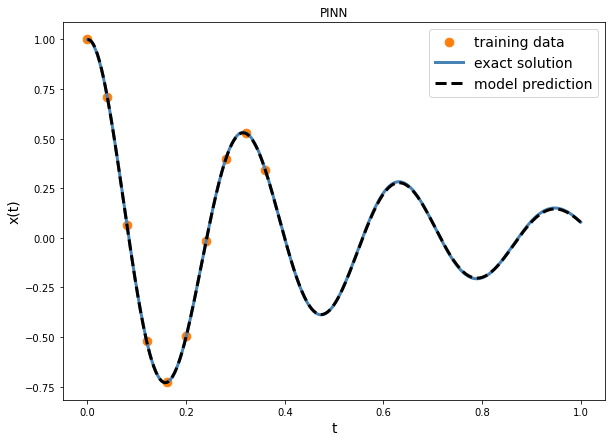

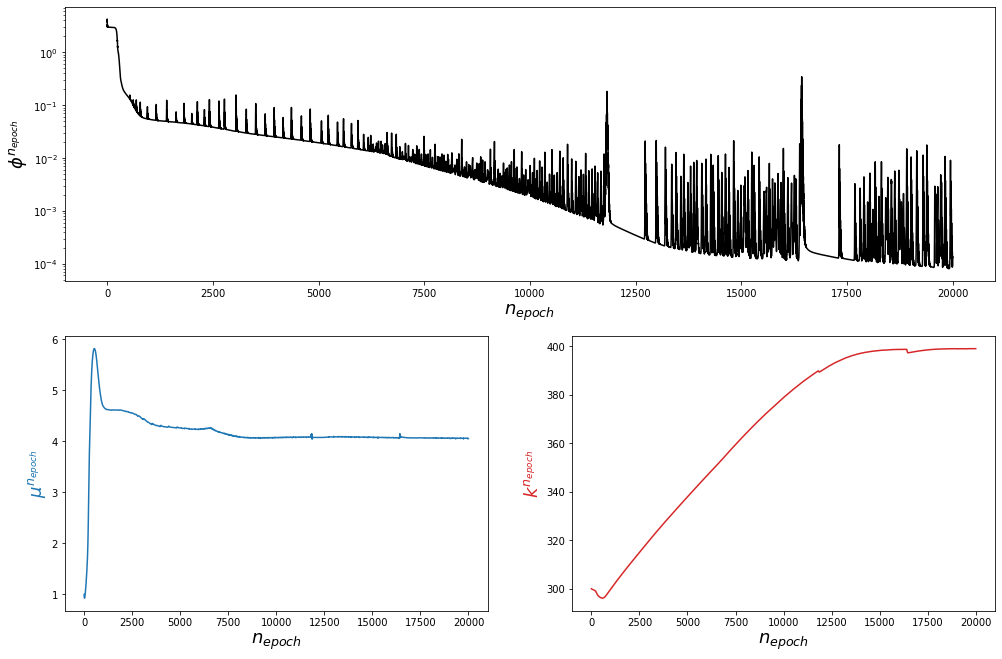

In [13]:
# plot loss history and model prediction
ax = solver.plot_solution();
axs = solver.plot_loss_and_param();
